In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Linear encoding models

Encoding models address the question of how the firing rate of a neuron is related to the stimulus that is presented. The most general way of describing an encoding model is:

$$r(t) = F(s; {p})$$

where $r(t)$ is the firing rate of a neuron at time $t$. $F$ is a function that maps the stimulus to the response rate using a set of parameters p. Linear encoding models are a specific subset of encoding models in which there is only a linear relation between the stimulus and the response:

$$r(t) = \sum_{x,y,t}w_{x,y,t}s_{x,y,t}$$

Here, the subscript $t$ is used to indicate that past stimulus values can contribute to the response at time t. Input stimuli can also have spatial dimensions and this is indicated with the subscripts $x,y$. Linear encoding models have the following two properties:
- Scaling the stimulus by a factor $\alpha$ will scale the response rate accordingly:

$$F(\alpha s) = \alpha F(s) = \alpha r(t)$$

- If we know the firing rate $r_1$ and $r_2$ for two different stimuli $s_1$ and $s_2$, then a neuron will respond to the sum of the two stimuli with a rate equal to the sum of the rates for the individual stimuli:

$$F(s_1 + s_2) = F(s_1) + F(s_2) = r_1(t) + r_2(t)$$


A biological example would be where we stimulate a neuron with a particular light intensity. If the firing rate depends linearly on this light intensity then the first property tells us that doubling (or halving) the light intensity should double (or halve) the firing rate of the neuron. The second property says that adding two light intensities together should produce a firing rate that is equal to the sum of the firing rates to each individual lights. This assumption of linearity does not hold really well in reality as neural firing rates cannot increase indefinitely. The notebook on the linear-nonlinear-Poisson model shows how to take these nonlinearities into account. Here we simply give examples of different linear response models.

In the first few examples we will use a stimulus that varies only with respect to time. The stimulus is a sine wave with frequency $f$ and amplitude $A$. To illustrate the effect of the encoding model we also added normal distributed noise to the stimulus:


$$s(t) = A \sin(2\pi f t) + \mathcal{N}(\mu,\,\sigma^{2})$$

In [3]:
# Definition of the stimulus
dt = 0.01                # Time step [s]
T  = 2                   # Total duration of the simulation
t = np.arange(0, 2, dt)  # Time points

f = 0.5 # Frequency
A = 1   # Amplitude
stim = A*np.sin(2*np.pi*f*t) + np.random.normal(0.0, 0.05, len(t))

### 1. Delayed amplification
For a stimulus that only depends on time we can write the response rate as follows:

$$r(t) = \sum_{\tau}^{N}w(\tau)s(t-\tau)$$

We choose the weights so that the firing rate at time $t$ is only determined by the stimulus value that was presented $N$ timesteps back. The stimulus value at that timepoint is scaled by a factor $\phi$ to determine the response rate. Because all the other weights are zero we can also write the response rate as folows:

$$r(t) = \phi s(t-N)$$

To simulate the effect of this model we use a for loop that looks at stimulus values 50 timesteps in the past and amplifies these stimulus values by a factor 1.5. This produces a curve that looks similar to the stimulus curve but shifted by 50 timesteps (0.5 seconds). Note that we have implictly assumed that stimulus values before $t = 0$ are all equal to zero, which is why the initial curve is zero.

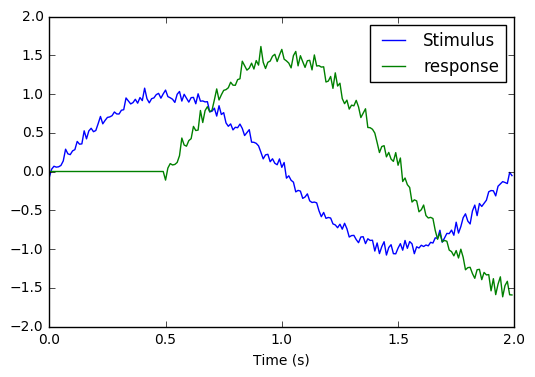

In [4]:
response = np.zeros(len(stim))
delay = 50
amplification = 1.5

for i in range(delay,len(stim)):
    response[i] = amplification*stim[i-delay]

plt.plot(t,stim)
plt.plot(t,response)
plt.xlabel('Time (s)')
plt.legend(['Stimulus','response'])

### 2. Running average
The next model takes multiple stimulus values into account. Specifically, we will let the weights of the N previous stimulus values equal 1/N. In that case the encoding model can be written as follows:

$$r(t) = \frac{1}{N}\sum_{\tau}^{N} s(t-\tau)$$

If N = 1 the response will simply follow the stimulus with a delay of one timestep. The effect for larger values of N is that the noise that was present in the stimulus will start to cancel out so that the result is a smoothed version of the stimulus delayed in time.

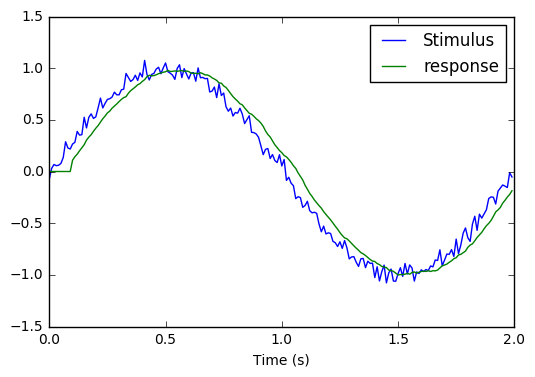

In [15]:
N= 10
response = np.zeros(len(stim))

for i in range(N, len(stim)):
        response[i] += np.sum(stim[(i-N):i])/N
        
plt.plot(t, stim)
plt.plot(t, response)
plt.xlabel('Time (s)')
plt.legend(['Stimulus','response'])

### 3. Leaky average
The weights can take a more complex form. In the following example they follow an exponential function where more recent stimulus values make a larger contribution to the sum than stimulus values in the past:

$$r(t) = \sum_{k}^{N} \exp(-\alpha k) s(t-k)$$

The parameter $\alpha$ controls the steepness of the exponential curve. For large values the curve will drop almost instantaneously and the response will simply follow the stimulus. For very small values, the curve can be almost flat and will approach the moving average model from the previous model. Note that for this to happen we need to make sure that the weights sum to one.

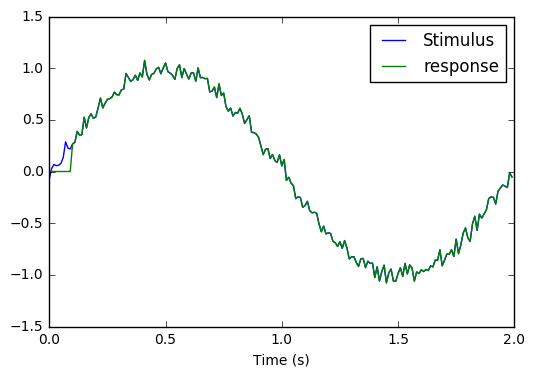

In [17]:
response = np.zeros(len(stim))
alpha = 30

la_filter = np.exp(-alpha*np.arange(0,N))
la_filter = la_filter/np.sum(la_filter)

for i in range(N, len(stim)):
    for k in range(N):
        response[i] += stim[i-k]*la_filter[k]
        
plt.plot(t, stim)
plt.plot(t, response)
plt.xlabel('Time (s)')
plt.legend(['Stimulus','response'])

### 4. Retinal ganglion cells

The previous models were meant as an illustration of what an encoding model is doing but they are not necessarily the most biologically plausible models. Here we introduce several models that correspond neurons that exist in the brain. The first model describes the firing rate of a retinal ganglion cell to a spatial stimulus. In this context, the weights that determine how the stimulus affects the response are also called the receptive field of that neuron.

$$r(t) = \sum_{x,y}w(x,y)s(x,y)$$

$$w(x,y) = \frac{1}{2\pi\sigma_c^2} \exp( -\frac{x^2 + y^2}{2\sigma_c^2}) - \frac{B}{2\pi\sigma_s^2}\exp({-\frac{x^2 + y^2}{2\sigma_s^2}})$$

This is called a difference of Gaussians model because we have two gaussian functions: one for the center with standard deviation $\sigma_c$ and one for the surround with parameter $\sigma_s$. The parameter $B$ determines the contribution of the surround to the receptive field. The stimulus is presented in a coordinate frame that assumes that the center of the stimulus corresponds to x = 0 and y = 0. 

In the following code we first construct an image with the values of the weights at their corresponding spatial location. An alternative view is provided in the plot on the right where we plot the weights at location y = 0. The black line represents a value of zero and this shows how a retinal ganglion cell as a center with positive weights surrounded by negative weights.

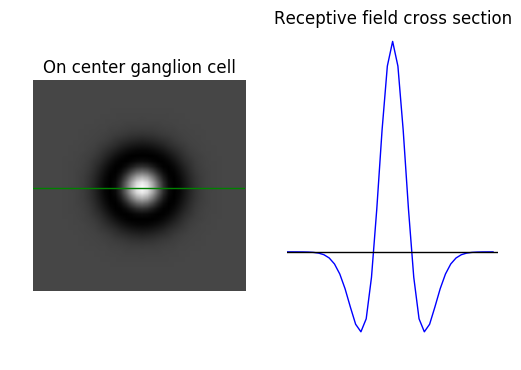

In [60]:
[X,Y] = np.meshgrid(np.arange(-2,2,0.1),np.arange(-2,2,0.1))
B = 1.3
sigma_c = 0.3
sigma_s = 0.4

rgc = (1/(2*np.pi*sigma_c**2))*np.exp(- (X**2 + Y**2)/(2*sigma_c**2)) - (B/(2*np.pi*sigma_s**2))*np.exp(- (X**2 + Y**2)/(2*sigma_s**2))

plt.subplot(1,2,1)
plt.imshow(rgc)
plt.axhline(20,color='g')
plt.title('On center ganglion cell')
plt.axis('off')
plt.subplot(1,2,2)
plt.plot(rgc[20,:])
plt.axis('off')
plt.axhline(0,color='k')
plt.title('Receptive field cross section')

### 5. Primary visual cortex simple cells

Another well known example of a spatial receptive fields is the simple cell that is found in primary visual cortex. The weights are described by a cosine function multiplied by a gaussian function:

$$w(x,y) = \exp(-\frac{x_r^2 + \gamma^2y_r^2}{2\sigma^2}) \cos(2\pi f x_r + \phi)$$

where
$$x_r =  x \cos\theta + y\sin\theta$$
$$y_r = -x \sin\theta + y\cos\theta$$

The cosine function has spatial frequency $f$ and phase offset $\phi$. The gaussian function has parameters \sigma that describes the width of the curve and a parameter $\gamma$ that specifies if the curve is stretched along one dimension.

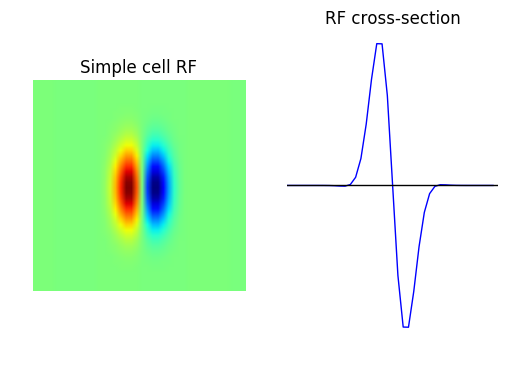

In [50]:
[X,Y] = np.meshgrid(np.arange(-2,2,0.1),np.arange(-2,2,0.1))

f     = 0.6     # Spatial frequency
theta = 0.0     # Orientation
phi   = np.pi/2 # Phase offset
sigma = 0.3     # Standard deviation of the gaussian kernel
gamma = 0.6     # Aspect ratio

X_rot = X*np.cos(theta) + Y*np.sin(theta)
Y_rot = -X*np.sin(theta) + Y*np.cos(theta)

g = np.exp( - (X_rot**2 + (gamma**2)*(Y_rot**2))/(2*sigma**2))*np.cos(2*np.pi*f*X_rot + phi)
plt.subplot(1,2,1)
plt.title('Simple cell RF')
plt.axis('off')
plt.imshow(g)
plt.subplot(1,2,2)
plt.plot(g[20,:])
plt.title('RF cross-section')
plt.axis('off')
plt.axhline(0,color='k')